# Houses 3D
## by Daniel

In [33]:
import requests
import json

# packages to manipulate tif files and read raster data
import rasterio as rio
import rioxarray as rxr
import pandas as pd

import matplotlib.pyplot as plt
import earthpy.plot as ep
import seaborn as sns


import plotly.graph_objects as go

import numpy as np
import zipfile

In [ ]:
The address for testing is in section 11 of the map, which is in one of the "smallest" file

<img src="images/sections.png" alt="drawing" width="900"/>

# HOW ? <br>
1. Obtain (via API) the geographic coordinates and dimensions of the property.<br>
2. Select the map to analyze.<br>
3. Download and extract the DTM map<br>
4. Download and extract the DSM map<br>
5. Unzip the files<br>
6. Calculate the Canopy Height Model ( DSM map - DTM map)<br>
7. Make an intersection between the canopy model and the property boundaries<br>
8. PLot the elevation data as a surface.

In [34]:
street='A. Verbouwelaan'
number='15'
post='8670'

In [35]:
#Create an empty list to store the polygone of the house
polygone=[]

Address API: Address -> Address ID1 <br />
Building Unit API: Addres ID1 -> Building Unit ID2 <br />
Building Unit API: Building Unit ID2 -> Building ID3 <br />
Building API: Building ID3 -> **Polygone**

In [36]:
def house_info(street, number, post):
    a=requests.get('https://api.basisregisters.dev-vlaanderen.be/v1/adressen?'+'straatnaam='+street+'&huisnummer='+number+'&postcode='+post+'&limit=1')
    b=a.json()
    id1= b['adressen'][0]['identificator']['objectId']
    print('Address found: Id1 is',id1)
    c=requests.get('https://api.basisregisters.vlaanderen.be/v1/gebouweenheden?adresObjectId='+id1)
    d=c.json()
    id2= d['gebouweenheden'][0]['identificator']['objectId']
    print('Building units found: Id2 is',id2)
    e=requests.get('https://api.basisregisters.vlaanderen.be/v1/gebouweenheden/'+id2)
    f=e.json()
    id3= f['gebouw']['objectId']
    print('Building found: Id3 is',id3)
    g=requests.get('https://api.basisregisters.vlaanderen.be/v1/gebouwen/'+id3)
    h=g.json()
    poly=h['geometriePolygoon']['polygon']['coordinates'][0]
    polygone.append(poly)

In [37]:
house_info(street, number, post)

Address found: Id1 is 20074984
Building units found: Id2 is 20074995
Building found: Id3 is 16145178


In [38]:
x=polygone[0][0][0]
y=polygone[0][0][1]

There are two csv files in the directory, for DMS and DMT, both files show the extension of each tif file.


In [11]:
dtm_df= pd.read_csv('dtm_info.csv')
dtm_df.set_index('file', inplace=True)

### CSV  File Example

In [12]:
dtm_df.head()

,xmin,ymin,xmax,ymax
file,,,,
DHMVIIDTMRAS1m_k01.tif,145000.0,238000.0,162000.0,247000.0
DHMVIIDTMRAS1m_k02.tif,162000.0,238000.0,194000.0,250000.0
DHMVIIDTMRAS1m_k03.tif,194000.0,238000.0,206000.0,248000.0
DHMVIIDTMRAS1m_k04.tif,53000.0,218000.0,66000.0,225500.0
DHMVIIDTMRAS1m_k05.tif,66000.0,218000.0,98000.0,232000.0


In [13]:
dsm_df= pd.read_csv('dsm_info.csv')
dsm_df.set_index('file', inplace=True)

### Select the file to download based on the coordinates

In [14]:
file_dsm_selected = dsm_df.loc[
    (x < dsm_df.xmax) & (x > dsm_df.xmin) & (y < dsm_df.ymax) & (y > dsm_df.ymin)
]

dsm_selected = file_dsm_selected.index.format()[0]


In [15]:
file_dtm_selected = dtm_df.loc[
    (x < dtm_df.xmax) & (x > dtm_df.xmin) & (y < dtm_df.ymax) & (y > dtm_df.ymin)
]
dtm_selected = file_dtm_selected.index.format()[0]

### Build the links to download the right tif file, both for DSM and DMT

In [16]:
post_link_dtm= dtm_selected.split('.')[0]+'.zip'
post_link_dsm= dsm_selected.split('.')[0]+'.zip'

In [17]:
base_url_dtm="https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dtm-raster-1m/"
base_url_dsm="https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dsm-raster-1m/"

In [18]:
url_dtm=base_url_dtm+post_link_dtm
url_dsm=base_url_dsm+post_link_dsm

### Function to download files, both for DSM and DTM

In [19]:
def download_dtm(url_dtm):
    filename=url_dtm.split('/')[-1]
    r=requests.get(url_dtm, stream=True)
    if r.ok:
        with open(filename, 'wb') as file:
            for chunk in r.iter_content(1024*100):
                file.write(chunk)
    else:
        print('error')

In [20]:
def download_dsm(url_dsm):
    filename=url_dsm.split('/')[-1]
    r=requests.get(url_dsm, stream=True)
    if r.ok:
        with open(filename, 'wb') as file:
            for chunk in r.iter_content(1024*100):
                file.write(chunk)
    else:
        print('error')

### Download files

In [21]:
download_dtm(url_dtm)
download_dsm(url_dsm)

### Unzip files

In [22]:
targetdtm=url_dtm.split('/')[-1]
targetdsm=url_dsm.split('/')[-1]

In [23]:
handledtm = zipfile.ZipFile(targetdtm)
handledsm = zipfile.ZipFile(targetdsm)

In [24]:
handledtm.extract('GeoTIFF/'+dtm_selected)
handledsm.extract('GeoTIFF/'+dsm_selected)

'c:\\Users\\Daniel\\Documents\\BeCode_Projects\\houses3d\\GeoTIFF\\DHMVIIDSMRAS1m_k11.tif'

Read the right file as an array and at the same time clip the shape of the property. <br>
The shape of the property (called polygone) needs to be inside a list called geometries <br>
The Clip function extracts the map or the data of the specified area with the polygon.

In [39]:
geometries = [
    {
        'type': 'Polygon',
        'coordinates': polygone
    }
]

In [40]:
read_dsm = rxr.open_rasterio("GeoTIFF/" + dsm_selected).rio.clip(geometries, from_disk=True)
read_dtm = rxr.open_rasterio("GeoTIFF/" + dtm_selected).rio.clip(geometries, from_disk=True)

In [48]:
canopy =  read_dsm - read_dtm

In [50]:
canopy.rio.to_raster("clipped.tif")

In [51]:
with rio.open("clipped.tif") as img:
    chm = img.read(1)

### plot in a plane the selected clipped file + hillshade to look at it better 

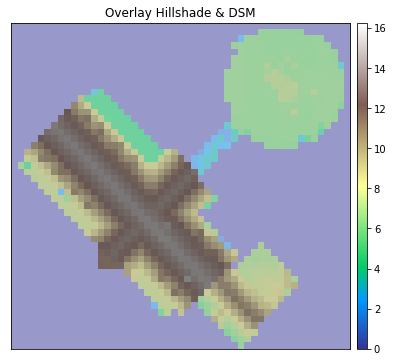

In [52]:
fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    chm, ax=ax, cmap="terrain", title="Overlay Hillshade & DSM",
)
ax.imshow(chm, cmap="Greys", alpha=0.5)
plt.show()


### plot the elevations

In [53]:

z = chm
sh_0, sh_1 = z.shape
x, y = np.linspace(0, 1, sh_0), np.linspace(0, 1, sh_1)
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig.update_layout(title='House', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

<img src="images/abbey.jpg" alt="abbey" width="600"/>

In [63]:
print('Altitude:',np.amax(z),'m')
print('Coordinates: '+str(polygone[0][0][0])+','+str(polygone[0][0][1]))
print('Municipality : Koksijde')

Altitude: 16.263638 m
Coordinates: 28158.00312703103,201377.95495779812
Municipality : Koksijde


### Pending things to do:

- Find a way to access maps without having to download them.

- Plot other information about the houses, such as diameter, area or other characteristics.

- Reshape the Code with an OOP approach

<img src="images/thanks.gif" alt="thanks" width="600"/>